In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
at_eur_1h = pd.read_csv('data/indicators_eurusd_1h.csv')

### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## RSI decision

In [3]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] < 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] > 70, 'dec_rsi'] = 'SELL'

    return df

In [4]:
decision_rsi(at_eur_1h)
at_eur_1h['dec_rsi'].value_counts()

dec_rsi
HOLD    4131
BUY      610
SELL     558
Name: count, dtype: int64

## Fuzzy RSI strategy
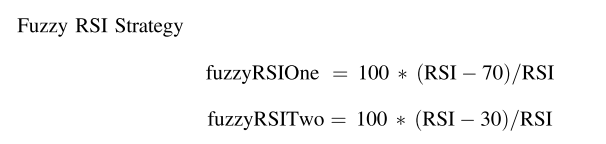

In [5]:
def fuzzRSIone(df):
    RSI = df['RSI']
    fuzzRSIone = 100 * (RSI - 70)/RSI
    return fuzzRSIone
    
def fuzzRSItwo(df):
    RSI = df['RSI']
    fuzzRSItwo = 100 * (RSI - 30)/RSI
    return fuzzRSItwo

at_eur_1h['fuzzRSIone'] = fuzzRSIone(at_eur_1h)

at_eur_1h['fuzzRSItwo'] = fuzzRSItwo(at_eur_1h)


In [8]:
at_eur_1h.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
id,5299.0,46877.832,8624.071,28851.000,41783.500,43108.000,44432.500,68836.000
Open,5299.0,1.081,0.017,1.045,1.068,1.082,1.093,1.126
Close,5299.0,1.081,0.017,1.045,1.068,1.082,1.093,1.126
High,5299.0,1.082,0.017,1.047,1.069,1.083,1.093,1.128
Low,5299.0,1.080,0.017,1.045,1.068,1.081,1.092,1.125
data_volume,5299.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Return,5299.0,-0.000,0.006,-0.046,-0.001,0.000,0.001,0.059
Up,5299.0,0.001,0.004,0.000,0.000,0.000,0.001,0.059
Down,5299.0,0.001,0.004,0.000,0.000,0.000,0.001,0.046
avg_14up,5299.0,0.001,0.001,0.000,0.000,0.000,0.001,0.013


In [9]:
at_eur_1h[['fuzzRSIone', 'fuzzRSItwo']].min()

fuzzRSIone   -2751.39715
fuzzRSItwo   -1122.02735
dtype: float64

In [6]:
# Ustalenie wartości high, low, normal na podstawie kwartyli i określenie dezycji 
# zwykłe RSI, bo fuzzyfikacja daje duże wartości ujemne
def create_signal_rsi(df, rsi_column):
        
    q25 = df[rsi_column].quantile(0.25)
    q50 = df[rsi_column].quantile(0.50)
    q75 = df[rsi_column].quantile(0.75)

    # Create column for RSI levels
    df['RSI_Level'] = 'Normal'
    df.loc[df[rsi_column] > q75, 'RSI_Level'] = 'High'  
    df.loc[df[rsi_column] < q25, 'RSI_Level'] = 'Low'  

    # Create column for trading decisions
    df['Signal_RSI_fuzz'] = 'HOLD'
    df.loc[df['RSI_Level'] == 'High', 'Signal_RSI_fuzz'] = 'BUY'  
    df.loc[df['RSI_Level'] == 'Low', 'Signal_RSI_fuzz'] = 'SELL' 
    
    return df

create_signal_rsi(at_eur_1h, 'RSI')

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,high_14,k_percent,B_MA,BU,BL,dec_rsi,fuzzRSIone,fuzzRSItwo,RSI_Level,Signal_RSI_fuzz
0,41482,EURUSD,1.06074,1.06056,1.06083,1.05995,0.0,2023-03-16 06:00:00.000,1h,EURUSD,...,1.07463,30.961727,1.064059,1.075502,1.052616,HOLD,-39.867711,40.056695,Normal,HOLD
1,41512,EURUSD,1.06297,1.06262,1.06334,1.06122,0.0,2023-03-17 12:00:00.000,1h,EURUSD,...,1.07463,41.069676,1.063649,1.074653,1.052646,HOLD,-38.792525,40.517489,Normal,HOLD
2,41537,EURUSD,1.07050,1.07238,1.07308,1.07030,0.0,2023-03-20 13:00:00.000,1h,EURUSD,...,1.07463,88.959764,1.063734,1.074986,1.052481,HOLD,-14.868965,50.770443,High,BUY
3,41562,EURUSD,1.07777,1.07741,1.07798,1.07608,0.0,2023-03-21 14:00:00.000,1h,EURUSD,...,1.07798,97.597977,1.064398,1.077209,1.051587,HOLD,-13.196395,51.487259,High,BUY
4,41592,EURUSD,1.08650,1.08551,1.08655,1.08546,0.0,2023-03-22 20:00:00.000,1h,EURUSD,...,1.08655,96.780186,1.065230,1.081066,1.049393,HOLD,-8.720474,53.405511,High,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,67712,EURUSD,1.06960,1.07016,1.07051,1.06901,0.0,2023-11-13 18:00:00.000,1h,EURUSD,...,1.07058,89.680590,1.069726,1.078503,1.060949,HOLD,-29.763310,44.387153,Normal,HOLD
5295,67702,EURUSD,1.06991,1.06957,1.07061,1.06936,0.0,2023-11-13 17:00:00.000,1h,EURUSD,...,1.07061,74.634146,1.069785,1.078540,1.061030,HOLD,-25.886087,46.048820,Normal,HOLD
5296,67682,EURUSD,1.06730,1.06769,1.06801,1.06679,0.0,2023-11-13 14:00:00.000,1h,EURUSD,...,1.07061,28.780488,1.069747,1.078533,1.060960,HOLD,-50.431282,35.529451,Normal,HOLD
5297,67698,EURUSD,1.06888,1.06992,1.07038,1.06852,0.0,2023-11-13 16:00:00.000,1h,EURUSD,...,1.07061,83.170732,1.069823,1.078586,1.061060,HOLD,-32.874367,43.053843,Normal,HOLD


In [7]:
at_eur_1h['Signal_RSI_fuzz'].value_counts()


Signal_RSI_fuzz
HOLD    2649
BUY     1325
SELL    1325
Name: count, dtype: int64


def create_signal_rsi(df):
    df['Signal_RSI_fuzz'] = 'HOLD'

    # Conditions for fuzzyRSIOne
    df.loc[df['fuzzRSIone'] == 'High', 'Signal_RSI_fuzz'] = 'BUY'
    df.loc[df['fuzzRSIone'] == 'Normal', 'Signal_RSI_fuzz'] = 'HOLD'
    df.loc[df['fuzzRSIone'] == 'Low', 'Signal_RSI_fuzz'] = 'HOLD'

    # Conditions for fuzzyRSITwo
    df.loc[df['fuzzRSItwo'] == 'High', 'Signal_RSI_fuzz'] = 'SELL'
    df.loc[df['fuzzRSItwo'] == 'Normal', 'Signal_RSI_fuzz'] = 'HOLD'
    df.loc[df['fuzzRSItwo'] == 'Low', 'Signal_RSI_fuzz'] = 'HOLD'

    return df['Signal_RSI_fuzz']

create_signal_rsi(at_eur_1h)
at_eur_1h.head()
at_eur_1h['Signal_RSI_fuzz'].value_counts()

In [14]:
FS = sf.FuzzySystem()

q1 = np.percentile(at_eur_1h['RSI'], 25)
q2 = np.percentile(at_eur_1h['RSI'], 50)  
q3 = np.percentile(at_eur_1h['RSI'], 75)

min_ = at_eur_1h['RSI'].min()
max_ = at_eur_1h['RSI'].max()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[min_, 1.], [q1, 1.], [q2, 0.]], term="low")
S2 = sf.FuzzySet(points=[[q1, 0.], [q2, 1.], [q3, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[q2, 0.], [q3, 1.], [max_, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[min_, max_])
FS.add_linguistic_variable("RSI", LV)



# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.5, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [15]:
at_eur_1h

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,k_percent,B_MA,BU,BL,dec_rsi,fuzzRSIone,fuzzRSItwo,RSI_Level,Signal_RSI_fuzz,Signal_RSI_fuzz_system
0,41482,EURUSD,1.06074,1.06056,1.06083,1.05995,0.0,2023-03-16 06:00:00.000,1h,EURUSD,...,30.961727,1.064059,1.075502,1.052616,HOLD,-39.867711,40.056695,Normal,HOLD,HOLD
1,41512,EURUSD,1.06297,1.06262,1.06334,1.06122,0.0,2023-03-17 12:00:00.000,1h,EURUSD,...,41.069676,1.063649,1.074653,1.052646,HOLD,-38.792525,40.517489,Normal,HOLD,HOLD
2,41537,EURUSD,1.07050,1.07238,1.07308,1.07030,0.0,2023-03-20 13:00:00.000,1h,EURUSD,...,88.959764,1.063734,1.074986,1.052481,HOLD,-14.868965,50.770443,High,BUY,SELL
3,41562,EURUSD,1.07777,1.07741,1.07798,1.07608,0.0,2023-03-21 14:00:00.000,1h,EURUSD,...,97.597977,1.064398,1.077209,1.051587,HOLD,-13.196395,51.487259,High,BUY,SELL
4,41592,EURUSD,1.08650,1.08551,1.08655,1.08546,0.0,2023-03-22 20:00:00.000,1h,EURUSD,...,96.780186,1.065230,1.081066,1.049393,HOLD,-8.720474,53.405511,High,BUY,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,67712,EURUSD,1.06960,1.07016,1.07051,1.06901,0.0,2023-11-13 18:00:00.000,1h,EURUSD,...,89.680590,1.069726,1.078503,1.060949,HOLD,-29.763310,44.387153,Normal,HOLD,HOLD
5295,67702,EURUSD,1.06991,1.06957,1.07061,1.06936,0.0,2023-11-13 17:00:00.000,1h,EURUSD,...,74.634146,1.069785,1.078540,1.061030,HOLD,-25.886087,46.048820,Normal,HOLD,HOLD
5296,67682,EURUSD,1.06730,1.06769,1.06801,1.06679,0.0,2023-11-13 14:00:00.000,1h,EURUSD,...,28.780488,1.069747,1.078533,1.060960,HOLD,-50.431282,35.529451,Normal,HOLD,HOLD
5297,67698,EURUSD,1.06888,1.06992,1.07038,1.06852,0.0,2023-11-13 16:00:00.000,1h,EURUSD,...,83.170732,1.069823,1.078586,1.061060,HOLD,-32.874367,43.053843,Normal,HOLD,HOLD


In [16]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    2003
BUY     1665
SELL    1631
Name: count, dtype: int64

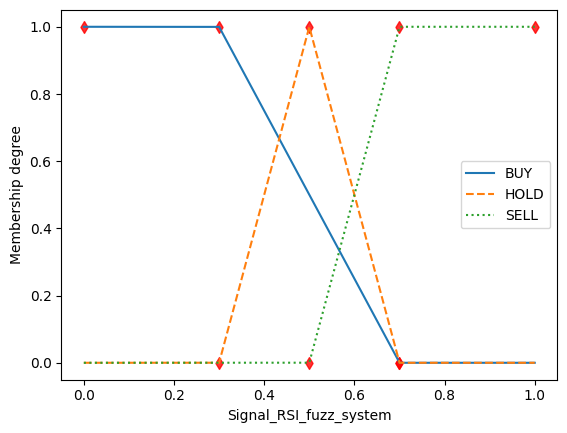

In [17]:
FS.plot_variable('Signal_RSI_fuzz_system')

# TESTY

In [32]:
# Function to perform fuzzy inference for each row and save the result in a new column
def infer_fuzzy_decision(row, fuzzy_system):
    fuzzy_system.set_variable('fuzzRSIone', row['fuzzRSIone'])
    fuzzy_system.set_variable('fuzzRSItwo', row['fuzzRSItwo'])
    result = fuzzy_system.inference()
    return result

# Using function for Bollinger Bands
rsi_fuzzy_system, rsi_variable = create_fuzzy_system_bollinger(at_eur_1h, 'fuzzRSIone', 'fuzzRSItwo', 'Signal_RSI')
rsi_variable.set_variable(at_eur_1h['fuzzRSIone'].mean())
at_eur_1h['fuzz_rsi_dec'] = at_eur_1h.apply(lambda row: infer_fuzzy_decision(row, rsi_fuzzy_system), axis=1)

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



AttributeError: 'FuzzySystem' object has no attribute 'linguistic_variable'

# skfuzzy

In [110]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
yf.pdr_override()

# Pobierz dane historyczne
data = pdr.get_data_yahoo("TSLA", start="2020-01-01", end="2022-12-31")

# Oblicz zmiany procentowe
delta = data['Close'].diff()

# Usuń brakujące wartości
delta = delta.dropna()

# Oblicz wzrosty i spadki
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

# Oblicz średnie kroczące
average_gain = up.rolling(window=14).mean()
average_loss = abs(down.rolling(window=14).mean())

# Oblicz wskaźnik siły względnej (RSI)
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))

# Definiuj zmienne rozmyte
rsi_ant = ctrl.Antecedent(np.arange(0, 101, 1), 'rsi')
rsi_ant['low'] = fuzz.trimf(rsi_ant.universe, [0, 30, 60])
rsi_ant['medium'] = fuzz.trimf(rsi_ant.universe, [30, 60, 90])
rsi_ant['high'] = fuzz.trimf(rsi_ant.universe, [60, 90, 100])

# Definiuj zmienne rozmyte dla consequent
decision = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'decision')
decision.automf(3)  # Create 3 fuzzy membership functions automatically

# Definiuj reguły rozmyte
rule1 = ctrl.Rule(antecedent=rsi_ant['low'], consequent=decision['poor'])
rule2 = ctrl.Rule(antecedent=rsi_ant['medium'], consequent=decision['average'])
rule3 = ctrl.Rule(antecedent=rsi_ant['high'], consequent=decision['good'])

# Stwórz system sterowania
rsi_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
rsi_decision = ctrl.ControlSystemSimulation(rsi_ctrl)

# Dodaj kolumny z RSI i sygnałami do ramki danych
data['RSI'] = rsi
data['fuzz_dec_rsi'] = 'HOLD'  # Dodaj nową kolumnę z domyślną decyzją 'HOLD'

# Generuj sygnały kupna i sprzedaży
for i, value in enumerate(rsi):
    rsi_decision.input['rsi'] = value
    rsi_decision.compute()
    decision = rsi_decision.output['decision']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_dec_rsi'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_dec_rsi'] = 'SELL'

# Wydrukuj ramkę danych z dodanymi kolumnami
print(data.dropna().head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2020-01-23  37.616669  38.799999  37.040001  38.146667  38.146667  294765000  \
2020-01-24  38.042000  38.257332  36.950668  37.654667  37.654667  215304000   
2020-01-27  36.132668  37.629333  35.952000  37.201332  37.201332  204121500   
2020-01-28  37.899334  38.453999  37.205334  37.793331  37.793331  176827500   
2020-01-29  38.379333  39.320000  37.828667  38.732666  38.732666  267022500   

                  RSI fuzz_dec_rsi  
Date                                
2020-01-23  81.575907         HOLD  
2020-01-24  77.761065         HOLD  
2020-01-27  74.460160         HOLD  
2020-01-28  73.404451         HOLD  
2020-01-29  72.209162         HOLD  


In [111]:
data['fuzz_dec_rsi'].value_counts()

fuzz_dec_rsi
HOLD    611
BUY     115
SELL     30
Name: count, dtype: int64

# Simpful

In [116]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import simpful as sf
yf.pdr_override()

# Pobierz dane historyczne
data = pdr.get_data_yahoo("TSLA", start="2020-01-01", end="2022-12-31")

# Oblicz zmiany procentowe
delta = data['Close'].diff()

# Usuń brakujące wartości
delta = delta.dropna()

# Oblicz wzrosty i spadki
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

# Oblicz średnie kroczące
average_gain = up.rolling(window=14).mean()
average_loss = abs(down.rolling(window=14).mean())

# Oblicz wskaźnik siły względnej (RSI)
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))

FS = sf.FuzzySystem()

# Define a linguistic variable for the input.
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [60, 0.]], term="low")
S2 = sf.FuzzySet(points=[[30, 0.], [60, 1.], [90, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[60, 0.], [90, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("rsi", LV)

# Define a linguistic variable for the output.
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="poor")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="average")
S3 = sf.FuzzySet(points=[[0.5, 0.], [0.7, 1.], [1.0, 1.]], term="good")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("decision", LV)

# Define fuzzy rules.
R1 = "IF (rsi IS low) THEN (decision IS poor)"
R2 = "IF (rsi IS medium) THEN (decision IS average)"
R3 = "IF (rsi IS high) THEN (decision IS good)"
FS.add_rules([R1, R2, R3])


# Dodaj kolumny z RSI i sygnałami do ramki danych
data['RSI'] = rsi
data['fuzz_dec_rsi'] = 'HOLD'  # Dodaj nową kolumnę z domyślną decyzją 'HOLD'

# Generuj sygnały kupna i sprzedaży
for i, value in enumerate(rsi):
    FS.set_variable("rsi", value)
    decision = FS.Mamdani_inference()['decision']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_dec_rsi'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_dec_rsi'] = 'SELL'

# Wydrukuj ramkę danych z dodanymi kolumnami
print(data.dropna().head())

[*********************100%***********************]  1 of 1 completed
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2020-01-23  37.616669  38.799999  37.040001  38.146667  38.146667  294765000  \
2020-01-24  38.042000  38.257332  36.950668  37.654667  37.654667  215304000   
2020-01-27  36.132668  37.629333  35.952000  37.201332  37.201332  204121500   
2020-01-28  37.899334  38.453999  37.205334  37.793331  37.793331  176827500   
2020-01-29  38.379333  39.320000  37.828667  38.732666  38.732666  267022500   

                  RSI fuzz_dec_rsi  
Date                                
2020-01-23  81.575907  

In [117]:
data['fuzz_dec_rsi'].value_counts()

fuzz_dec_rsi
HOLD    491
BUY     169
SELL     96
Name: count, dtype: int64

In [105]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import simpful as sf
yf.pdr_override()

# Pobierz dane historyczne
data = pdr.get_data_yahoo("TSLA", start="2020-01-01", end="2022-12-31")

# Oblicz zmiany procentowe
delta = data['Close'].diff()

# Usuń brakujące wartości
delta = delta.dropna()

# Oblicz wzrosty i spadki
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

# Oblicz średnie kroczące
average_gain = up.rolling(window=14).mean()
average_loss = abs(down.rolling(window=14).mean())

# Oblicz wskaźnik siły względnej (RSI)
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))

data['rsi'] = rsi


[*********************100%***********************]  1 of 1 completed


In [107]:
# Create a fuzzy system
FS = FuzzySystem()

# Define fuzzy variables and linguistic terms for RSI
rsi_variable = LinguisticVariable(
    FS_list=[
        AutoTriangle(3, universe_of_discourse=[0, 25, 50], terms="LOW"),
        AutoTriangle(3, universe_of_discourse=[25, 50, 75], terms="MEDIUM"),
        AutoTriangle(3, universe_of_discourse=[50, 75, 100], terms="HIGH"),
    ],
    concept="rsi",
    universe_of_discourse=[0, 100],
)

FS.add_linguistic_variable("rsi", rsi_variable)

# Define rules for the fuzzy system
r1 = "IF (rsi IS LOW) THEN (fuzz_dec_rsi IS LOW)"
r2 = "IF (rsi IS MEDIUM) THEN (fuzz_dec_rsi IS MEDIUM)"
r3 = "IF (rsi IS HIGH) THEN (fuzz_dec_rsi IS HIGH)"
FS.add_rules([r1, r2, r3])

# Define fuzzy outputs and linguistic terms for decision
decision_variable = LinguisticVariable(FS_list=[
    TriangleFuzzySet(0, 50, 100, term="LOW"),
    TriangleFuzzySet(0, 50, 100, term="MEDIUM"),
    TriangleFuzzySet(0, 50, 100, term="HIGH"),
], concept="fuzz_dec_rsi", universe_of_discourse=[0, 100])

FS.add_linguistic_variable('fuzz_dec_rsi', decision_variable)

# Add RSI and decision columns to the data frame
data['fuzz_dec_rsi'] = 'HOLD'  # Add a new column with the default decision 'HOLD'

# Generate buy, sell, or hold signals
for i, value in enumerate(data['rsi']):
    # Set RSI value in the fuzzy system
    FS.set_variable("rsi", value)

    # Perform inference
    decision = FS.inference()

    # Set decision back to the data frame
    data.loc[data.index[i], 'fuzz_dec_rsi'] = decision_variable.get_linguistic_term(decision)

# Print the data frame with the added columns
print(data.head())

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



AttributeError: 'AutoTriangle' object has no attribute 'get_value'